In [57]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import importlib

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import and reload modules to get fresh changes
from src.models.predictor import TrollPredictor
from src.data_tools.czech_data_tools import load_czech_media_data
import src.models.predictor
importlib.reload(src.models.predictor )

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

In [58]:
# Reinitialize the predictor after reload
predictor = TrollPredictor(
    model_path='../checkpoints/best_model.pt',
    comments_per_user=5,
    max_length=64
)

In [59]:
MODEL_DIR = Path('../checkpoints')
DATA_DIR = Path('../data')

# Initialize predictor with best model
predictor = TrollPredictor(
    model_path=str(MODEL_DIR / 'best_model.pt'),
    comments_per_user=5,
    max_length=64
)

In [60]:
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading files: 100%|██████████████████████████████████████████████████████| 124/124 [00:04<00:00, 25.32it/s]


Loaded 846098 comments from 66607 unique authors


In [61]:
# Display data info
print("\nDataset columns:", czech_comments.columns.tolist())
print("\nSample of comments:")
print(czech_comments[['text', 'author', 'sentiment']].head())


Dataset columns: ['text', 'author', 'timestamp', 'article_title', 'url', 'article_id', 'sentiment']

Sample of comments:
                                                text        author   sentiment
0                        Umí i něco jiného než lhát?   Jiří Mraček    Negative
1  Nezávislost na Rusku je lež jako věž z Ruska b...  Fiala Václav    Negative
2  Vsak jak jinak. Pořád si stěžovali, že se musí...   Jana Krejci     Neutral
3  Jedna reforma školství stíhá druhou, hlavně ab...   Jiří Flusek     Neutral
4  Frantisek LuftNaštěstí to vychází z logiky int...   Honza Novak  Ambivalent


In [9]:
# Save processed data
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)
czech_comments.to_parquet(PROCESSED_DIR / 'czech_media_comments.parquet')

In [10]:
# Make Predictions
results = []
for idx, group in tqdm(czech_comments.groupby('author')):
    texts = group['text'].tolist()
    
    # Get prediction
    pred = predictor.predict_batch(texts)
    
    # Store results
    results.append({
        'author': idx,
        'n_comments': len(texts),
        'prediction': pred['prediction'],
        'confidence': pred['confidence'],
        'troll_probability': pred['probabilities'][1]
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████| 66607/66607 [05:58<00:00, 185.76it/s]


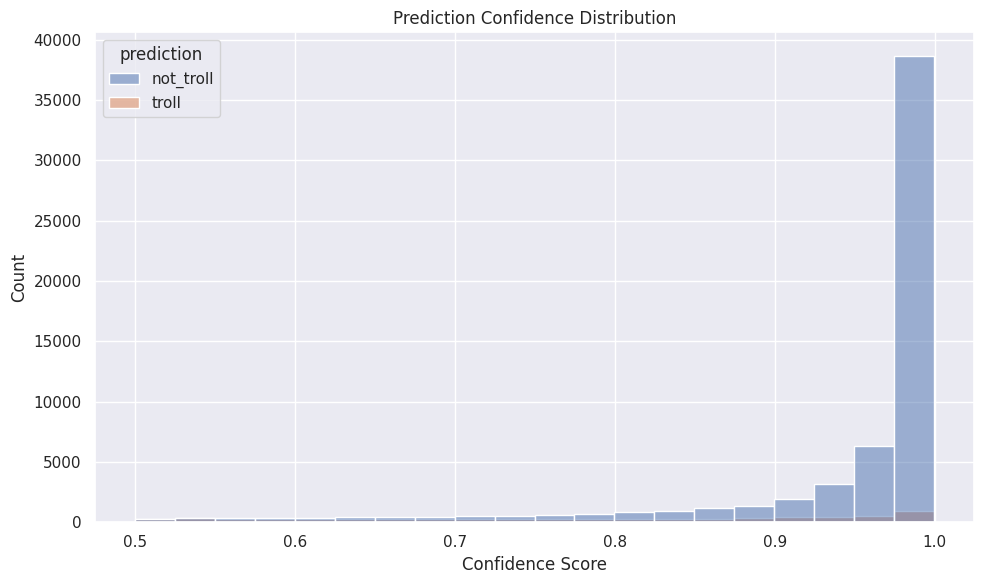


=== High Confidence Troll Predictions ===

Found 2351 high confidence troll predictions

--- High Confidence Prediction 1 ---
Author: Viktor Šrámek
Confidence: 0.997
Troll Probability: 0.997

Sample comments:
--------------------------------------------------------------------------------
Trump kolaboroval s Ruskem !!!
----------------------------------------

--- High Confidence Prediction 2 ---
Author: Petr Riman
Confidence: 0.997
Troll Probability: 0.997

Sample comments:
--------------------------------------------------------------------------------
Trump velmi precizně!
----------------------------------------

--- High Confidence Prediction 3 ---
Author: Zbenda Z
Confidence: 0.997
Troll Probability: 0.997

Sample comments:
--------------------------------------------------------------------------------
Ein Musk fur alle der kleine Trump hilfer :)
----------------------------------------

=== Uncertain Predictions (Medium Confidence) ===

Found 1047 medium confidence predictions

In [11]:
# Cell: Analyze predictions by confidence levels
# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(
    data=results_df, 
    x='confidence', 
    hue='prediction', 
    bins=20
)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print analysis of high confidence predictions
print("\n=== High Confidence Troll Predictions ===")
high_conf_trolls = results_df[
    (results_df['prediction'] == 'troll') & 
    (results_df['confidence'] >= 0.9)
].sort_values('confidence', ascending=False)

if len(high_conf_trolls) > 0:
    print(f"\nFound {len(high_conf_trolls)} high confidence troll predictions")
    for i, (_, row) in enumerate(high_conf_trolls.head(3).iterrows(), 1):
        print(f"\n--- High Confidence Prediction {i} ---")
        print(f"Author: {row['author']}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Troll Probability: {row['troll_probability']:.3f}")
        print("\nSample comments:")
        print("-" * 80)
        # Get comments for this author
        author_comments = czech_comments[czech_comments['author'] == row['author']]['text'].head(2)
        for comment in author_comments:
            print(comment[:200] + "..." if len(comment) > 200 else comment)
            print("-" * 40)
else:
    print("No high confidence troll predictions found")

# Print analysis of uncertain predictions
print("\n=== Uncertain Predictions (Medium Confidence) ===")
medium_conf = results_df[
    (results_df['confidence'] >= 0.6) & 
    (results_df['confidence'] < 0.7) &
    (results_df['prediction'] == 'troll')
].sort_values('confidence')

if len(medium_conf) > 0:
    print(f"\nFound {len(medium_conf)} medium confidence predictions")
    for i, (_, row) in enumerate(medium_conf.head(3).iterrows(), 1):
        print(f"\n--- Medium Confidence Prediction {i} ---")
        print(f"Author: {row['author']}")
        print(f"Prediction: {row['prediction']}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Troll Probability: {row['troll_probability']:.3f}")
        print("\nSample comments:")
        print("-" * 80)
        # Get comments for this author
        author_comments = czech_comments[czech_comments['author'] == row['author']]['text'].head(2)
        for comment in author_comments:
            print(comment[:200] + "..." if len(comment) > 200 else comment)
            print("-" * 40)
else:
    print("No medium confidence predictions found")

# Save detailed results
output_dir = Path('../output')
output_dir.mkdir(exist_ok=True)
high_conf_trolls.to_csv(output_dir / 'high_confidence_predictions.csv', index=False)
medium_conf.to_csv(output_dir / 'medium_confidence_predictions.csv', index=False)

In [12]:
results_df.head()

,author,n_comments,prediction,confidence,troll_probability
0,*,1,not_troll,0.707831,0.292169
1,007 Bradley,1,not_troll,0.970445,0.029555
2,1. Jiří Kratochvíl,5,not_troll,0.990438,0.009562
3,11345,1,not_troll,0.993912,0.006088
4,1zus,1,not_troll,0.996915,0.003085


In [14]:
from src.data_tools.czech_data_tools import export_troll_comments_by_confidence

export_troll_comments_by_confidence(
    predictions_df=results_df,
    comments_df=czech_comments,
    min_confidence=0.9,
    output_file="../output/troll_comments_by_confidence.json"
)

Processing comments: 100%|██████████████████████████████████████████████| 2351/2351 [02:16<00:00, 17.28it/s]



Exported 16228 comments from 2351 authors
Output saved to: ../output/troll_comments_by_confidence.json


In [54]:
def explain_author(
    author_name: str, 
    predictor_instance: TrollPredictor, 
    comments_df: pd.DataFrame, 
    display_plots: bool = True,
):
    """Interactive function to explain why an author was classified as a troll using multiple methods"""
    
    # Get author's comments
    author_comments = comments_df[comments_df['author'] == author_name]['text'].tolist()
    
    if not author_comments:
        print(f'No comments found for author: {author_name}')
        return
        
    # Get prediction first
    pred = predictor_instance.predict_batch(author_comments)
    
    if pred['prediction'] != 'troll':
        print(f'Author {author_name} is not classified as a troll (confidence: {pred["confidence"]:.3f})')
        return
    
    print(f"\nAnalyzing author: {author_name}")
    print(f"Prediction confidence: {pred['confidence']:.3f}")
    print(f"Troll probability: {pred['probabilities'][1]:.3f}")
    
    # Generate occlusion sensitivity explanation
    print("\n=== Occlusion Sensitivity Analysis ===")
    explanation = predictor_instance.explain_prediction(author_comments)
    
    # Print occlusion sensitivity results
    for i, exp in enumerate(explanation['explanations'], 1):
        print(f"\nComment {i}:")
        print(f"Text: {exp['tweet_text']}")
        print("\nMost influential tokens (Occlusion Sensitivity):")
        
        # Create a table with token contributions
        contrib_data = []
        for contrib in exp['token_contributions']:
            direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
            contrib_data.append([
                contrib['token'],
                f"{contrib['importance']:.4f}",
                direction
            ])
        
        contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
        print(contrib_df.to_string(index=False))
        
        if display_plots:
            img = plt.imread(exp['plot_filename'])
            plt.figure(figsize=(12, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Occlusion Sensitivity Analysis - Comment {i}')
            plt.show()
        
        print("-" * 80)
    
    # # Generate correlation analysis if requested
    # if use_correlation:
    #     print("\n=== Token Correlation Analysis ===")
    #     correlation_explanation = predictor_instance.explain_with_correlation(author_comments)
        
    #     for i, exp in enumerate(correlation_explanation['explanations'], 1):
    #         print(f"\nComment {i}:")
    #         print(f"Text: {exp['tweet_text']}")
    #         print("\nMost influential tokens (Correlation Analysis):")
            
    #         # Create a table with token contributions
    #         contrib_data = []
    #         for contrib in exp['token_contributions']:
    #             direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
    #             contrib_data.append([
    #                 contrib['token'],
    #                 f"{contrib['importance']:.4f}",
    #                 direction
    #             ])
            
    #         contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
    #         print(contrib_df.to_string(index=False))
            
    #         if display_plots:
    #             img = plt.imread(exp['plot_filename'])
    #             plt.figure(figsize=(12, 4))
    #             plt.imshow(img)
    #             plt.axis('off')
    #             plt.title(f'Token Correlation Analysis - Comment {i}')
    #             plt.show()
            
    #         print("-" * 80)


Analyzing author: Josef Hůzl
Prediction confidence: 0.611
Troll probability: 0.611

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/5
Occlusion analysis for Tweet 1:
Text: pan. president se probudil, proto, že mu hoří koudel.
Plot saved to: importance_tweet_1.png
Top contributing tokens:
  - 'president': 0.2656 (supporting the prediction)
  - 'proto': -0.0652 (opposing the prediction)
  - '.': -0.0473 (opposing the prediction)
  - '.': -0.0457 (opposing the prediction)
  - 'pan': -0.0453 (opposing the prediction)
  - 'že': 0.0323 (supporting the prediction)
  - 'ko': 0.0250 (supporting the prediction)
  - 'mu': 0.0203 (supporting the prediction)
  - '##il': 0.0194 (supporting the prediction)
  - 'ho': 0.0129 (supporting the prediction)

Processing tweet 2/5
Occlusion analysis for Tweet 2:
Text: nějak brzo.
Plot saved to: importance_tweet_2.png
Top contributing tokens:
  - 'něj': -0.0817 (opposing the prediction)
  - '.

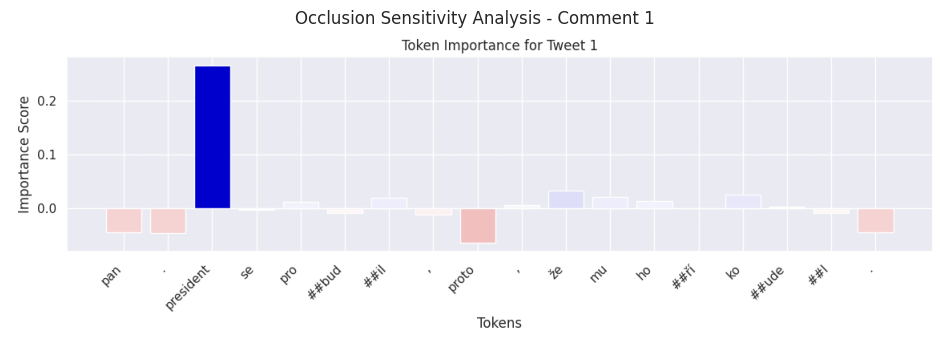

--------------------------------------------------------------------------------

Comment 2:
Text: nějak brzo.

Most influential tokens (Occlusion Sensitivity):
Token Importance   Effect
  něj    -0.0817 Opposing
    .    -0.0472 Opposing
 brzo    -0.0286 Opposing
 ##ak    -0.0246 Opposing


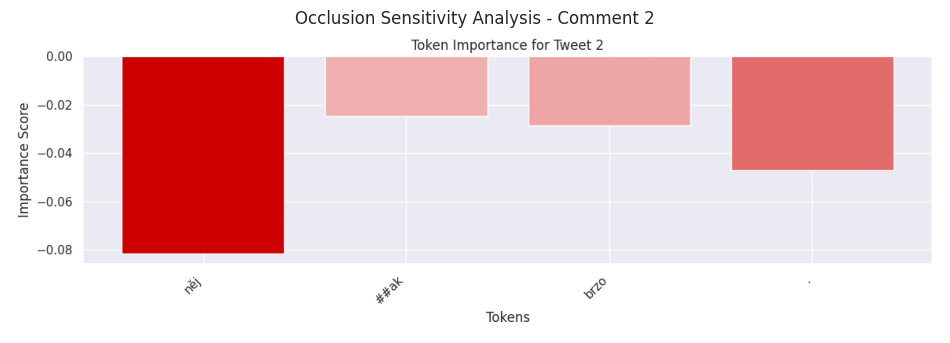

--------------------------------------------------------------------------------

Comment 3:
Text: stanislav lehkýono se počká na nejmenší cenu a pak si ji nějaký koupí.

Most influential tokens (Occlusion Sensitivity):
Token Importance     Effect
##lav     0.0657 Supporting
 ##is     0.0526 Supporting
  ##ý    -0.0335   Opposing
  něj    -0.0308   Opposing
 cenu     0.0296 Supporting
 ##ší    -0.0281   Opposing
    a     0.0277 Supporting
   le    -0.0252   Opposing
   se    -0.0250   Opposing
  ##č    -0.0248   Opposing


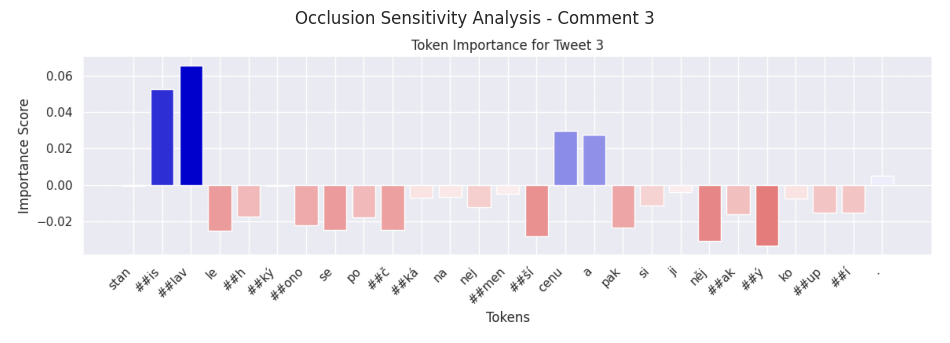

--------------------------------------------------------------------------------

Comment 4:
Text: pan. president se probudil, proto, že mu hoří koudel.

Most influential tokens (Occlusion Sensitivity):
    Token Importance     Effect
president     0.2656 Supporting
    proto    -0.0652   Opposing
        .    -0.0473   Opposing
        .    -0.0457   Opposing
      pan    -0.0453   Opposing
       že     0.0323 Supporting
       ko     0.0250 Supporting
       mu     0.0203 Supporting
     ##il     0.0194 Supporting
       ho     0.0129 Supporting


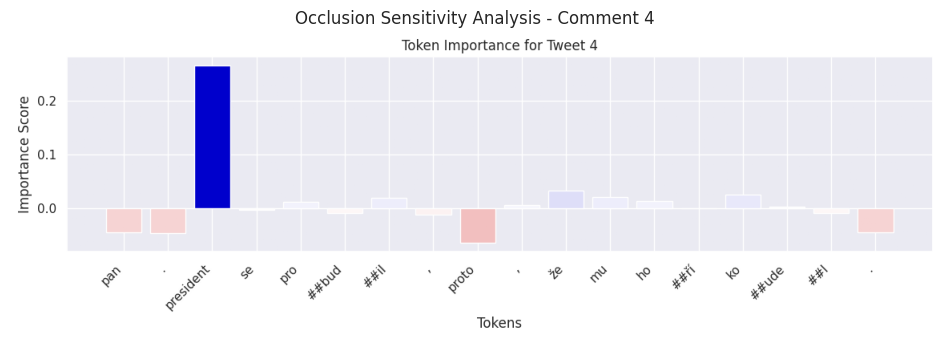

--------------------------------------------------------------------------------

Comment 5:
Text: nějak brzo.

Most influential tokens (Occlusion Sensitivity):
Token Importance   Effect
  něj    -0.0817 Opposing
    .    -0.0472 Opposing
 brzo    -0.0286 Opposing
 ##ak    -0.0246 Opposing


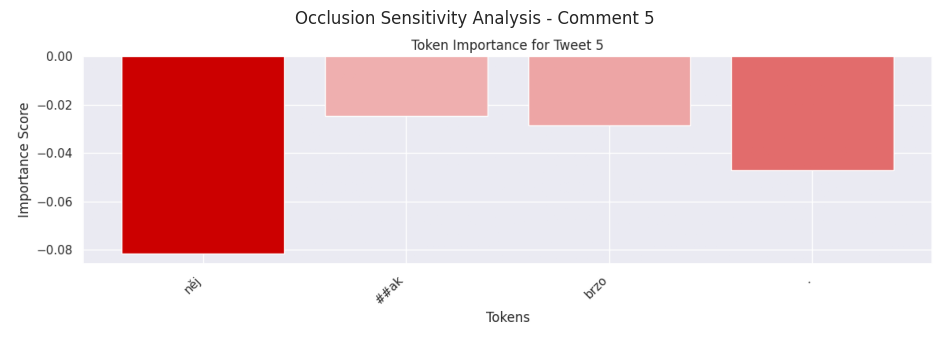

--------------------------------------------------------------------------------



Analyzing author: Johny Death
Prediction confidence: 0.636
Troll probability: 0.636

=== Occlusion Sensitivity Analysis ===

Generating explanations using occlusion sensitivity...

Processing tweet 1/5
Occlusion analysis for Tweet 1:
Text: tak zastupitel kurske oblasti muset mít nové slonovinové drbatko . na slovensku jsou fakt klauni.
Plot saved to: importance_tweet_1.png
Top contributing tokens:
  - '##itel': 0.0329 (supporting the prediction)
  - 'oblasti': 0.0293 (supporting the prediction)
  - 'tak': -0.0267 (opposing the prediction)
  - 'na': -0.0257 (opposing the prediction)
  - '##ens': 0.0228 (supporting the prediction)
  - '.': -0.0188 (opposing the prediction)
  - '##i': -0.0181 (opposing the prediction)
  - 'mít': -0.0154 (opposing the prediction)
  - 'fakt': -0.0147 (opposing the prediction)
  - '##stup': 0.0139 (supporting the prediction)

Processing tweet 2/5
Occlusion analysis for Tweet 

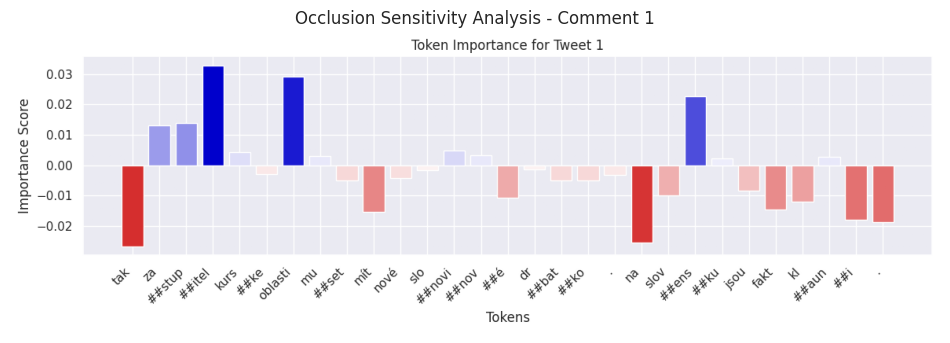

--------------------------------------------------------------------------------

Comment 2:
Text: tak zastupitel kurske oblasti muset mít nové slonovinové drbatko . na slovensku jsou fakt klauni.

Most influential tokens (Occlusion Sensitivity):
  Token Importance     Effect
 ##itel     0.0329 Supporting
oblasti     0.0293 Supporting
    tak    -0.0267   Opposing
     na    -0.0257   Opposing
  ##ens     0.0228 Supporting
      .    -0.0188   Opposing
    ##i    -0.0181   Opposing
    mít    -0.0154   Opposing
   fakt    -0.0147   Opposing
 ##stup     0.0139 Supporting


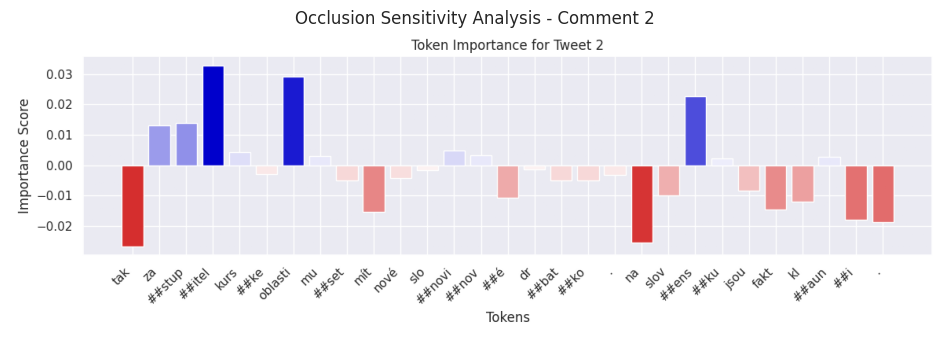

--------------------------------------------------------------------------------

Comment 3:
Text: tak zastupitel kurske oblasti muset mít nové slonovinové drbatko . na slovensku jsou fakt klauni.

Most influential tokens (Occlusion Sensitivity):
  Token Importance     Effect
 ##itel     0.0329 Supporting
oblasti     0.0293 Supporting
    tak    -0.0267   Opposing
     na    -0.0257   Opposing
  ##ens     0.0228 Supporting
      .    -0.0188   Opposing
    ##i    -0.0181   Opposing
    mít    -0.0154   Opposing
   fakt    -0.0147   Opposing
 ##stup     0.0139 Supporting


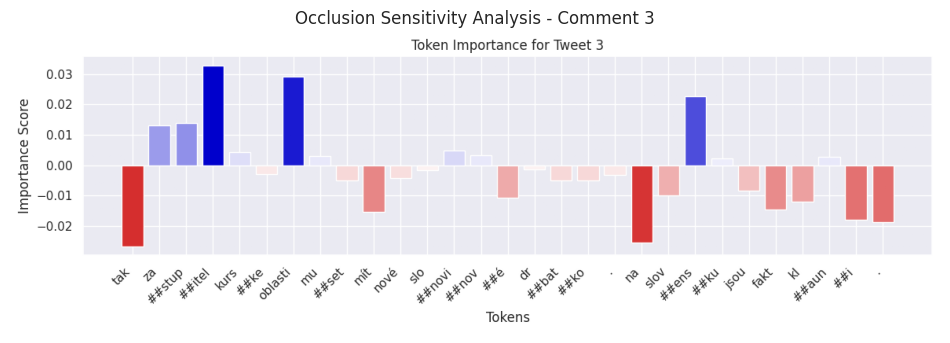

--------------------------------------------------------------------------------

Comment 4:
Text: tak zastupitel kurske oblasti muset mít nové slonovinové drbatko . na slovensku jsou fakt klauni.

Most influential tokens (Occlusion Sensitivity):
  Token Importance     Effect
 ##itel     0.0329 Supporting
oblasti     0.0293 Supporting
    tak    -0.0267   Opposing
     na    -0.0257   Opposing
  ##ens     0.0228 Supporting
      .    -0.0188   Opposing
    ##i    -0.0181   Opposing
    mít    -0.0154   Opposing
   fakt    -0.0147   Opposing
 ##stup     0.0139 Supporting


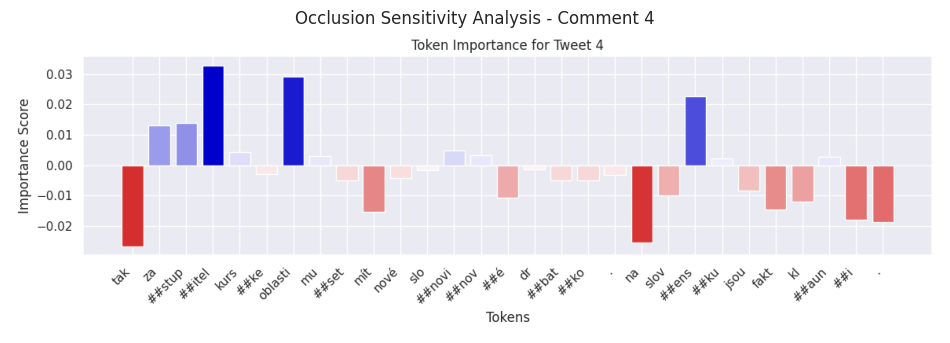

--------------------------------------------------------------------------------

Comment 5:
Text: tak zastupitel kurske oblasti muset mít nové slonovinové drbatko . na slovensku jsou fakt klauni.

Most influential tokens (Occlusion Sensitivity):
  Token Importance     Effect
 ##itel     0.0329 Supporting
oblasti     0.0293 Supporting
    tak    -0.0267   Opposing
     na    -0.0257   Opposing
  ##ens     0.0228 Supporting
      .    -0.0188   Opposing
    ##i    -0.0181   Opposing
    mít    -0.0154   Opposing
   fakt    -0.0147   Opposing
 ##stup     0.0139 Supporting


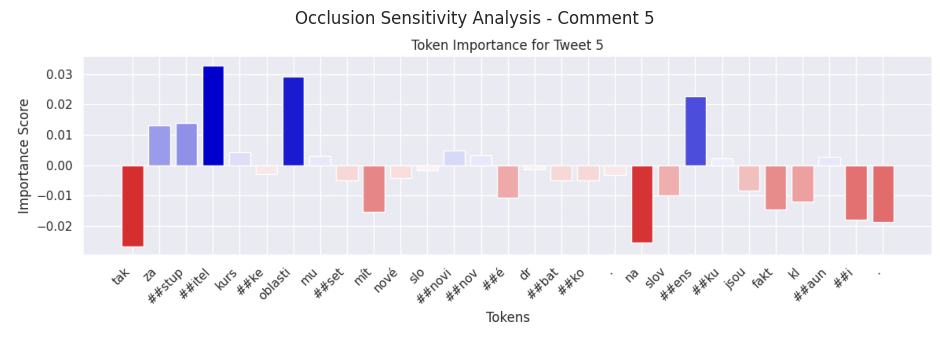

--------------------------------------------------------------------------------




In [56]:
# Example usage
# authors_to_explain = [
#     "Jitka Bártová",
#     "Roman Myška",   
# ]
authors_to_explain = [
    "Josef Hůzl",
    "Johny Death",   
]


for author in authors_to_explain:
    explain_author(
        author_name=author,
        predictor_instance=predictor,
        comments_df=czech_comments,
        display_plots=True,
    )
    print("\n" + "="*80 + "\n")

In [52]:
# List names of medium confidence trolls
medium_conf_trolls = results_df[
    (results_df['confidence'] >= 0.6) & 
    (results_df['confidence'] < 0.7) & 
    (results_df['prediction'] == 'troll')
]

# Display the names
medium_conf_troll_names = medium_conf_trolls['author'].tolist()
print("Medium confidence trolls (confidence between 0.6 and 0.7):")
print(medium_conf_troll_names)

Medium confidence trolls (confidence between 0.6 and 0.7):
['Adam E Marek', 'Adam Kepert', 'Adam Luk', 'Adam Šišák', 'Adela Kralikova', 'Albert Horák', 'Alca Furstova', 'Alena Adámková', 'Alena Bláhová', 'Alena Dvorožňáková', 'Alena Hirschkornova', 'Alena Splavcová', 'Alena Řešetková', 'Ales Bednar', 'Alex Hauser', 'Alex Milkov', 'Alexandr Barton', 'Aleš Fišer', 'Aleš Jančík', 'Aleš Kožíšek', 'Aleš Palla', 'Aleš Ronner', 'Algika Čechová', 'Alois Kukačka', 'Andrea Šťastná', 'Andrej Zavadsky', 'Anna Liftnerova', 'Anna Smejkal', 'Anteran Cole', 'Antonin Kubasek', 'Antonio Serutti', 'Antonín Hadač', 'Antonín Huleš', 'Ardenau Pracl', 'Arnold Schlehuber', 'Arnošt Kvasnička', 'Arsen Lúpin', 'Astra Bohumin', 'Bara S', 'Barbora Havlikova', 'Bass Basmann', 'Bedrich Vich', 'Bedřich Ost', 'Ben Rendys', 'Blanka Celko', 'Blanka Dolejš', 'Blazena Blahutova', 'Bogdan Tomoszek', 'Bohumil Drábik', 'Bohuslav Brož', 'Bohuslav Březina', 'Bohuslav Hrbek', 'Bohuslav Kočárek', 'Bohysek', 'Borec', 'Boris Hamle